# Training an MLP on MNIST with Numpy

In this Notebook we will implement and train Multi-Layer Perceptron on the MNIST dataset.

## Load and prepare the Dataset

In [23]:
!pip install scikit-learn

In [24]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y = True)
X = X.values # To return the values into array
y = y.astype(int).values

In [25]:
# Preprocessing the data
X = ((X / 255.0) - .5) * 2 # Here we rescale the pixel values to train more effectively

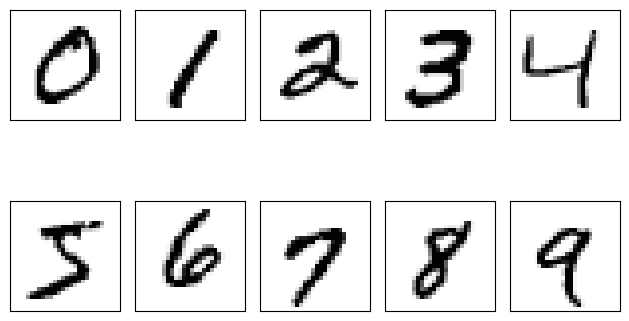

In [26]:
# Visualize our sample digits
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Train-Validation-Test split

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=55000, random_state=123)

In [28]:
X_train.shape, X_val.shape, X_test.shape

((55000, 784), (5000, 784), (10000, 784))

In [29]:
y_train.shape, y_val.shape, y_test.shape

((55000,), (5000,), (10000,))

## Create Mini - batches

In [30]:
!pip install numpy

import numpy as np

In [31]:
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

## Core componets of MLP

### Linear Layer

In [32]:
class Linear:
    def __init__(self, in_features, out_features):
        # TODO
        self.weight = np.random.rand(in_features, out_features)  # Initialize the weight randomly.
        self.bias = np.zeros(out_features) # Initialize the bias to all zeros.

        self.grad_weight = np.zeros((in_features, out_features)) # Initialize the weight gradient to zeros. The shape should same as self.weight
        self.grad_bias = np.zeros(out_features) # Initialize the bias gradient to zeros. The shape should same as self.bias

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        self.input = x # Do not remove. Needed for backward computation

        # The general Linear equation
        output = np.dot(x, self.weight) + self.bias # TODO: Compute the net input based in the linear equation.
        return output

    def backward(self, grad_output):
        grad_input = np.dot(grad_output, self.weight.T)

        self.grad_weight[...] = np.dot(self.input.T, grad_output)
        self.grad_bias[...] = np.mean(grad_output, axis=0)
        return grad_input

    def parameters(self):
        """Returns the parameters of your linear layer"""
        return [self.weight, self.bias]

    def gradients(self):
        """Returns the gradients for the parameters of your linear layer"""
        return [self.grad_weight, self.grad_bias]

### Sigmoid Activation Function

In [33]:
class Sigmoid:
    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        self.output = 1 /(1 + np.exp(x)) # TODO: Compute the sigmoid equation
        return self.output

    def backward(self, grad_output):
        return grad_output * self.output * (1 - self.output)

### Mean Squared Error Loss

In [34]:
class MSELoss:
    def __call__(self, pred, target):
        return self.forward(pred, target)

    def forward(self, pred, target):
        self.pred = pred # Do not remove. Needed for backward computation
        self.target = target # Do not remove. Needed for backward computation
        error = np.mean((self.pred - self.target)**2) # TODO: Compute the mean square error function
        return error

    def backward(self):
        return 2. * (self.pred - self.target) / self.target.shape[0]

## Gradient Descent Optimizer

In [35]:
class SGD:
    def __init__(self, params, grads, lr=0.1):
        self.params = params
        self.grads = grads
        self.lr = lr

    def step(self):
        """Update the parameters (weight and bias) of your netork using the Gradient Descent algorithm."""
        for p, g in zip(self.params, self.grads):
            p -= self.lr * g # gradient descent

    def zero_grad(self):
        """Zeros out the gradient of your network"""
        for g in self.grads:
            g.fill(0.0)

## Assembling the MLP

In [36]:
class MLP:
    def __init__(self, in_features, hidden_size, out_features):
        # TODO Initialize your network

        # Do not change this variable names. The are needed for backward computation
        self.linear1 = Linear(in_features, hidden_size)
        self.act1 = Sigmoid()
        self.linear2 = Linear(hidden_size, out_features)
        self.act2 = Sigmoid()

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        """Forward propagation through your network"""
        # TODO Pass x (input) to your network and get y (output)
        z1 = self.linear1(x) # For the net input of the hidden layer
        a1 = self.act1(z1) # Activation for the hidden layer
        z2 = self.linear2(a1)
        y = self.act2(z2) # Activation of the hidden layer
        return y

    def backward(self, grad_output):
        """Backpropagation through your network"""
        grad_z2 = self.act2.backward(grad_output)
        grad_a1 = self.linear2.backward(grad_z2)

        grad_z1 = self.act1.backward(grad_a1)
        _ = self.linear1.backward(grad_z1)

    def parameters(self):
        """Return the parameters of your entire model/network"""
        return self.linear1.parameters() + self.linear2.parameters()

    def gradients(self):
        """Return the gradients of your entire model/network"""
        return self.linear1.gradients() + self.linear2.gradients()

## Training and Evaluation

In [37]:
# Converting the integer laberl to one-hot vectors
# And we use `One-Hot encoding` for support comparison scope
def int_to_onehot(y, num_labels=10):
      return np.eye(num_labels)[y]

loss_fn = MSELoss() # Add the loss function

In [38]:
def train(model, train_loader, optimizer, criterion):
    total_loss = 0.0
    num_samples = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        preds = model(X_batch)
        loss = criterion(preds, int_to_onehot(y_batch))

        grad_output = loss_fn.backward() # Gradient of the loss w.r.t output

        model.backward(grad_output)
        optimizer.step()

        total_loss += loss
        num_samples += len(y_batch)

    return total_loss / num_samples

In [39]:
# Computes the loss and accuracy on the validation set

def valid(model, valid_loader, criterion):
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for X_batch, y_batch in valid_loader:
        preds = model(X_batch)
        loss = criterion(preds, int_to_onehot(y_batch))

        total_loss += loss

        predicted_labels = np.argmax(preds, axis=1)
        correct_predictions += (predicted_labels == y_batch).sum()
        total_predictions += len(y_batch)

    total_loss /= total_predictions
    accuracy = (correct_predictions / total_predictions)*100
    return total_loss, accuracy

## Instantiate Model, Loss function and Optimizer

In [40]:
in_features = 28 * 28      # Each image is 28x28 pixels
hidden_size = 50           # Size of the hidden layer (can experiment)
out_features = 10          # One output per digit class (0-9)
learning_rate = 0.1        # Step size for SGD updates

np.random.seed(123)        # For reproducible results

model = MLP(in_features=in_features, hidden_size=hidden_size, out_features=out_features)

loss_fn = MSELoss()

optimizer = SGD(model.parameters(), model.gradients(), lr=learning_rate)

## Training Loop

In [41]:
num_epochs = 70
batch_size = 100

for epoch in range(num_epochs):
    # Usually in the PyTorch way, dataloader SHOULD NOT be in the epoch loop
    train_loader = minibatch_generator(X_train, y_train, minibatch_size=batch_size)
    valid_loader = minibatch_generator(X_val, y_val, minibatch_size=batch_size)

    train_loss = train(model, train_loader, optimizer, criterion=loss_fn)
    valid_loss, valid_acc = valid(model, valid_loader, criterion=loss_fn)

    print(f"Epoch: {epoch+1:02d}/{num_epochs} | Train MSE: {train_loss:.4f} | Valid MSE: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%")

Epoch: 01/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc: 9.58%
Epoch: 02/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc: 9.58%
Epoch: 03/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc: 9.58%
Epoch: 04/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc: 9.58%
Epoch: 05/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc: 9.58%
Epoch: 06/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc: 9.58%
Epoch: 07/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc: 9.58%
Epoch: 08/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc: 9.58%
Epoch: 09/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc: 9.58%
Epoch: 10/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc: 9.58%
Epoch: 11/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc: 9.58%
Epoch: 12/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc: 9.58%
Epoch: 13/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc: 9.58%
Epoch: 14/70 | Train MSE: 0.0010 | Valid MSE: 0.0010 | Valid Acc

In [42]:
# Measure the final generalization
def test(model, test_loader):
    correct_predictions = 0
    total_predictions = 0
    for X_batch, y_batch in test_loader:
        preds = model(X_batch)

        predicted_labels = np.argmax(preds, axis=1)
        correct_predictions += (predicted_labels == y_batch).sum()
        total_predictions += len(y_batch)

    accuracy = (correct_predictions / total_predictions)*100
    return accuracy


test_loader = minibatch_generator(X_test, y_test, minibatch_size=100)
test_acc = test(model, test_loader)
print(f'Test accuracy: {test_acc:.2f}%')#

Test accuracy: 9.63%
